In [410]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import random
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_validate
import xgboost as xgb

pl.Config.set_fmt_str_lengths(50)
random.seed(121923)
delivery_data = pl.read_csv('/Users/ryanquach/Downloads/delivery_data.csv')

In [411]:
delivery_data.head(n = 10)

ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,i64,str,str,str,str,str,str
"""0x4607 ""","""INDORES13DEL02 ""","""37""","""4.9""",22.745049,75.892471,22.765049,75.912471,"""19-03-2022""","""11:30:00""","""11:45:00""","""conditions Sunny""","""High """,2,"""Snack ""","""motorcycle ""","""0""","""No ""","""Urban ""","""(min) 24"""
"""0xb379 ""","""BANGRES18DEL02 ""","""34""","""4.5""",12.913041,77.683237,13.043041,77.813237,"""25-03-2022""","""19:45:00""","""19:50:00""","""conditions Stormy""","""Jam """,2,"""Snack ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 33"""
"""0x5d6d ""","""BANGRES19DEL01 ""","""23""","""4.4""",12.914264,77.6784,12.924264,77.6884,"""19-03-2022""","""08:30:00""","""08:45:00""","""conditions Sandstorms""","""Low """,0,"""Drinks ""","""motorcycle ""","""1""","""No ""","""Urban ""","""(min) 26"""
"""0x7a6a ""","""COIMBRES13DEL02 ""","""38""","""4.7""",11.003669,76.976494,11.053669,77.026494,"""05-04-2022""","""18:00:00""","""18:10:00""","""conditions Sunny""","""Medium """,0,"""Buffet ""","""motorcycle ""","""1""","""No ""","""Metropolitian ""","""(min) 21"""
"""0x70a2 ""","""CHENRES12DEL01 ""","""32""","""4.6""",12.972793,80.249982,13.012793,80.289982,"""26-03-2022""","""13:30:00""","""13:45:00""","""conditions Cloudy""","""High """,1,"""Snack ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 30"""
"""0x9bb4 ""","""HYDRES09DEL03 ""","""22""","""4.8""",17.431668,78.408321,17.461668,78.438321,"""11-03-2022""","""21:20:00""","""21:30:00""","""conditions Cloudy""","""Jam """,0,"""Buffet ""","""motorcycle ""","""1""","""No ""","""Urban ""","""(min) 26"""
"""0x95b4 ""","""RANCHIRES15DEL01 ""","""33""","""4.7""",23.369746,85.33982,23.479746,85.44982,"""04-03-2022""","""19:15:00""","""19:30:00""","""conditions Fog""","""Jam """,1,"""Meal ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 40"""
"""0x9eb2 ""","""MYSRES15DEL02 ""","""35""","""4.6""",12.352058,76.60665,12.482058,76.73665,"""14-03-2022""","""17:25:00""","""17:30:00""","""conditions Cloudy""","""Medium """,2,"""Meal ""","""motorcycle ""","""1""","""No ""","""Metropolitian ""","""(min) 32"""
"""0x1102 ""","""HYDRES05DEL02 ""","""22""","""4.8""",17.433809,78.386744,17.563809,78.516744,"""20-03-2022""","""20:55:00""","""21:05:00""","""conditions Stormy""","""Jam """,0,"""Buffet ""","""motorcycle ""","""1""","""No ""","""Metropolitian ""","""(min) 34"""


## Data Cleaning

In [412]:
def haversine(long_start, lat_start, long_end, lat_end):
    long_start, lat_start, long_end, lat_end = map(np.radians, [long_start, lat_start, long_end, lat_end])
    
    long_dist = long_end - long_start 
    lat_dist = lat_end - lat_start 
    a = np.sin(lat_dist/2) ** 2 + np.cos(lat_start) * np.cos(lat_end) * np.sin(long_dist/2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6371 * c
    return km

delivery_data = (delivery_data
                .select(pl.exclude(['ID', 'Delivery_person_ID', 'Vehicle_condition', 'Order_Date', 
                                    'Time_Orderd', 'Time_Order_picked', 'multiple_deliveries']))
                .select(pl.all().name.map(lambda col_name: col_name.lower()))
                .rename({'restaurant_latitude': 'orig_lat',
                         'restaurant_longitude': 'orig_long',
                         'delivery_location_latitude': 'dest_lat',
                         'delivery_location_longitude': 'dest_long',
                         'weatherconditions': 'weather',
                         'road_traffic_density': 'traffic_density',
                         'time_taken(min)': 'time_taken'})
                .with_columns(abs(pl.col('orig_lat')).alias('orig_lat'))
                .with_columns([pl.col('weather').str.to_lowercase().str.replace('conditions ', ''),
                               pl.col('type_of_order').str.to_lowercase().str.strip_chars(),
                               pl.col('traffic_density').str.to_lowercase().str.strip_chars(),
                               pl.col('type_of_vehicle').str.strip_chars(),
                               pl.col('festival').str.to_lowercase().str.strip_chars(),
                               pl.col('city').str.to_lowercase().str.strip_chars(),
                               pl.col('time_taken').str.replace('\(min\) ', '')])    
                .with_columns(haversine(pl.col('orig_long'), pl.col('orig_lat'), 
                                        pl.col('dest_long'), pl.col('dest_lat')).alias('distance').round(2))
                .with_columns([pl.col('delivery_person_age').str.replace('NaN ', '10000').cast(pl.Int16),
                               pl.col('delivery_person_ratings').str.replace('NaN ', '10000').cast(pl.Float32),
                               pl.col('distance').str.replace('NaN ', '10000').cast(pl.Float32).round(2),
                               pl.col('time_taken').str.replace('NaN ', '10000').cast(pl.Int16)])
                .select(pl.exclude(['orig_lat', 'orig_long', 'dest_lat', 'dest_long']))
                .select(pl.exclude('time_taken'), pl.col('time_taken'))
                )

delivery_data.head(n = 10)

delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
i16,f32,str,str,str,str,str,str,f32,i16
37,4.9,"""sunny""","""high""","""snack""","""motorcycle""","""no""","""urban""",3.03,24
34,4.5,"""stormy""","""jam""","""snack""","""scooter""","""no""","""metropolitian""",20.18,33
23,4.4,"""sandstorms""","""low""","""drinks""","""motorcycle""","""no""","""urban""",1.55,26
38,4.7,"""sunny""","""medium""","""buffet""","""motorcycle""","""no""","""metropolitian""",7.79,21
32,4.6,"""cloudy""","""high""","""snack""","""scooter""","""no""","""metropolitian""",6.21,30
22,4.8,"""cloudy""","""jam""","""buffet""","""motorcycle""","""no""","""urban""",4.61,26
33,4.7,"""fog""","""jam""","""meal""","""scooter""","""no""","""metropolitian""",16.6,40
35,4.6,"""cloudy""","""medium""","""meal""","""motorcycle""","""no""","""metropolitian""",20.209999,32
22,4.8,"""stormy""","""jam""","""buffet""","""motorcycle""","""no""","""metropolitian""",19.98,34


In [413]:
delivery_data = delivery_data.filter(~pl.col('weather').str.contains('nan'),
                                     ~pl.col('traffic_density').str.contains('nan'),
                                     ~pl.col('type_of_order').str.contains('nan'),
                                     ~pl.col('type_of_vehicle').str.contains('nan'),
                                     ~pl.col('festival').str.contains('nan'),
                                     ~pl.col('city').str.contains('nan'),
                                     ~(pl.col('delivery_person_age') == 10000.0), 
                                     ~(pl.col('delivery_person_ratings') == 10000.0),
                                     ~(pl.col('distance') == 10000.0),
                                     ~(pl.col('time_taken') == 10000.0))

In [414]:
delivery_data.head(n = 10)

delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
i16,f32,str,str,str,str,str,str,f32,i16
37,4.9,"""sunny""","""high""","""snack""","""motorcycle""","""no""","""urban""",3.03,24
34,4.5,"""stormy""","""jam""","""snack""","""scooter""","""no""","""metropolitian""",20.18,33
23,4.4,"""sandstorms""","""low""","""drinks""","""motorcycle""","""no""","""urban""",1.55,26
38,4.7,"""sunny""","""medium""","""buffet""","""motorcycle""","""no""","""metropolitian""",7.79,21
32,4.6,"""cloudy""","""high""","""snack""","""scooter""","""no""","""metropolitian""",6.21,30
22,4.8,"""cloudy""","""jam""","""buffet""","""motorcycle""","""no""","""urban""",4.61,26
33,4.7,"""fog""","""jam""","""meal""","""scooter""","""no""","""metropolitian""",16.6,40
35,4.6,"""cloudy""","""medium""","""meal""","""motorcycle""","""no""","""metropolitian""",20.209999,32
22,4.8,"""stormy""","""jam""","""buffet""","""motorcycle""","""no""","""metropolitian""",19.98,34


In [415]:
delivery_data.describe()

describe,delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
str,f64,f64,str,str,str,str,str,str,f64,f64
"""count""",42260.0,42260.0,"""42260""","""42260""","""42260""","""42260""","""42260""","""42260""",42260.0,42260.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",29.597089,4.633897,null,null,null,null,null,null,9.757879,26.475982
"""std""",5.762773,0.315244,null,null,null,null,null,null,5.607937,9.335128
"""min""",20.0,2.5,"""cloudy""","""high""","""buffet""","""electric_scooter""","""no""","""metropolitian""",1.47,10.0
"""25%""",25.0,4.5,null,null,null,null,null,null,4.66,19.0
"""50%""",30.0,4.7,null,null,null,null,null,null,9.22,26.0
"""75%""",35.0,4.9,null,null,null,null,null,null,13.68,33.0
"""max""",39.0,5.0,"""windy""","""medium""","""snack""","""scooter""","""yes""","""urban""",20.969999,54.0


## Data Visualization

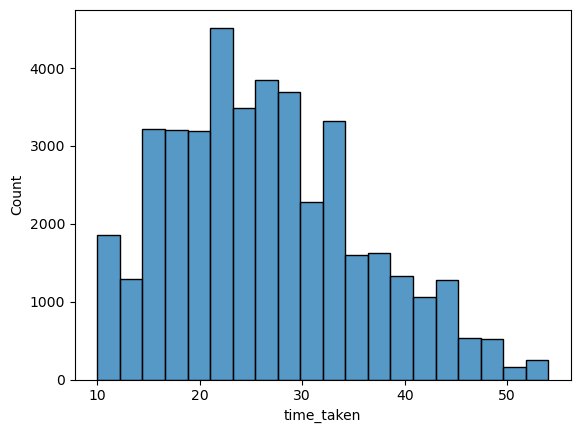

In [416]:
sns.histplot(data = delivery_data.to_pandas(), x = 'time_taken', bins = 20);

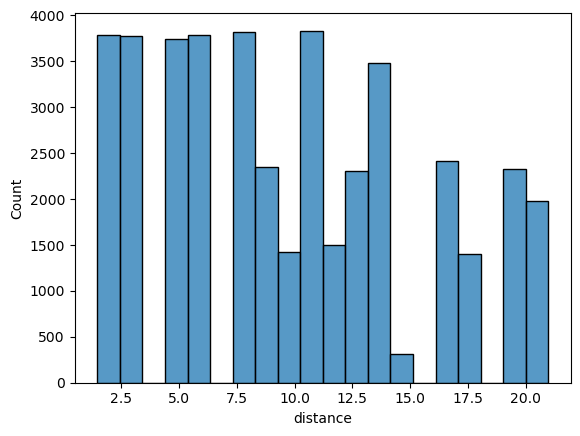

In [417]:
sns.histplot(data = delivery_data.to_pandas(), x = 'distance', bins = 20);

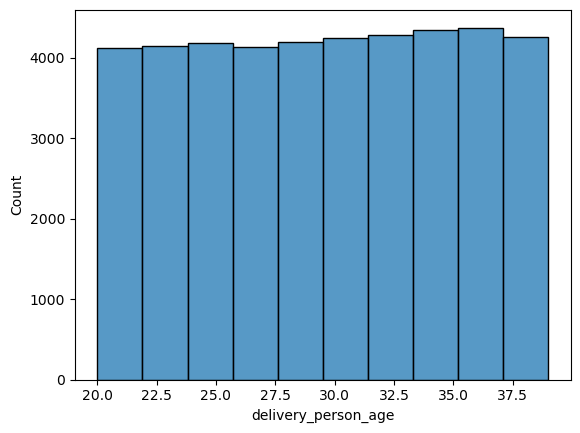

In [418]:
sns.histplot(data = delivery_data.to_pandas(), x = 'delivery_person_age', bins = 10);

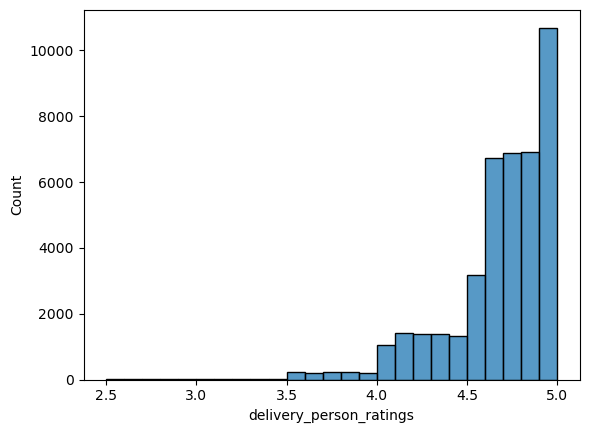

In [419]:
sns.histplot(data = delivery_data.to_pandas(), x = 'delivery_person_ratings', bins = 25);

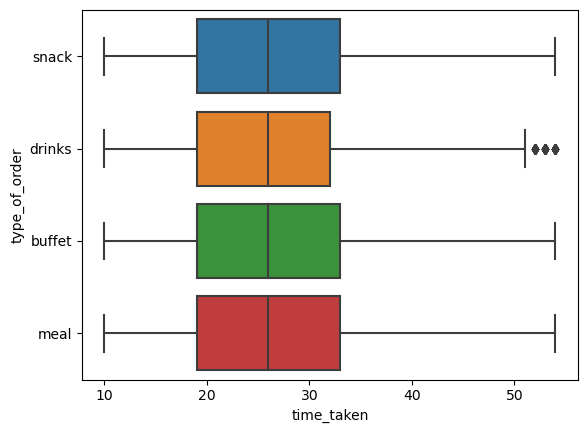

In [420]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'type_of_order');

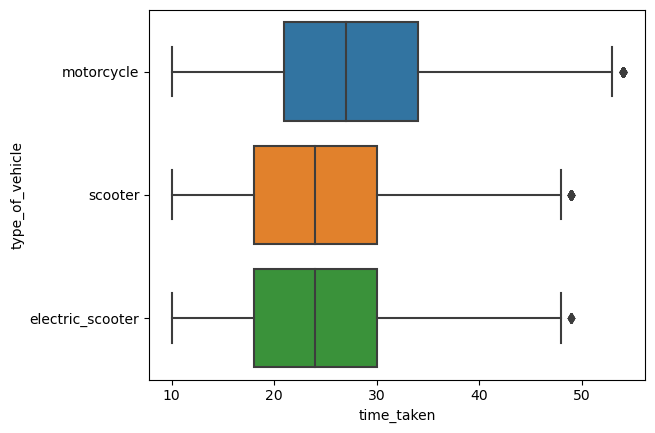

In [421]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'type_of_vehicle');

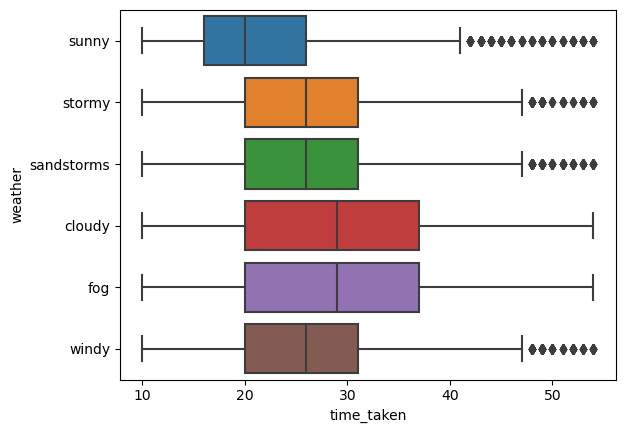

In [422]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'weather');

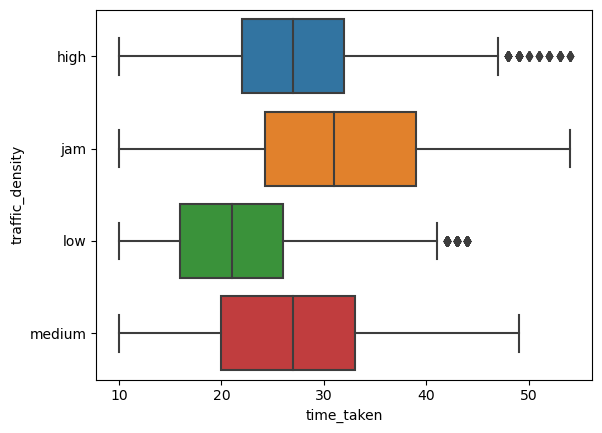

In [423]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'traffic_density');

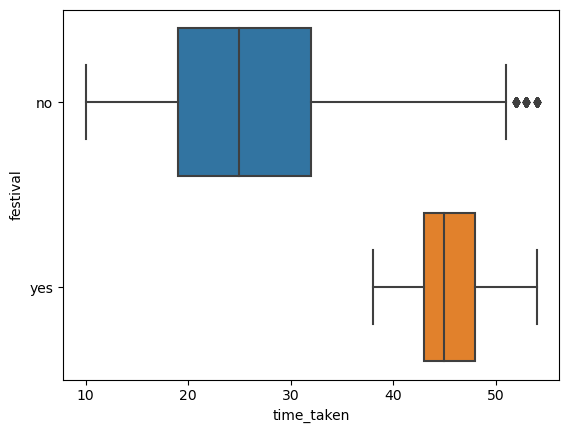

In [424]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'festival');

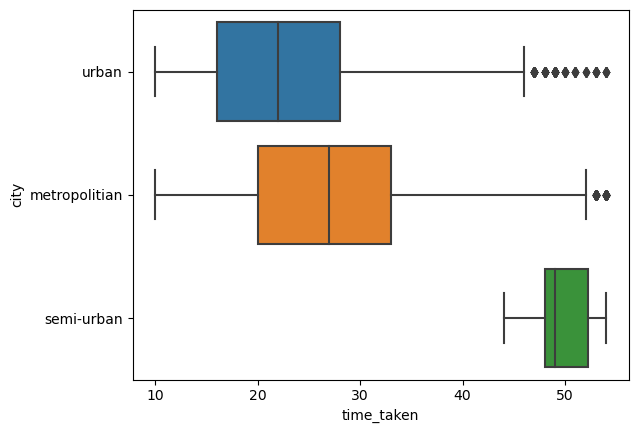

In [425]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'city');

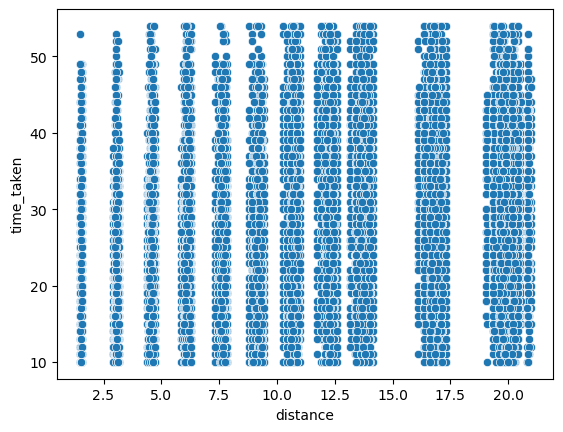

In [426]:
sns.scatterplot(data = delivery_data.to_pandas(), x = 'distance', y = 'time_taken');

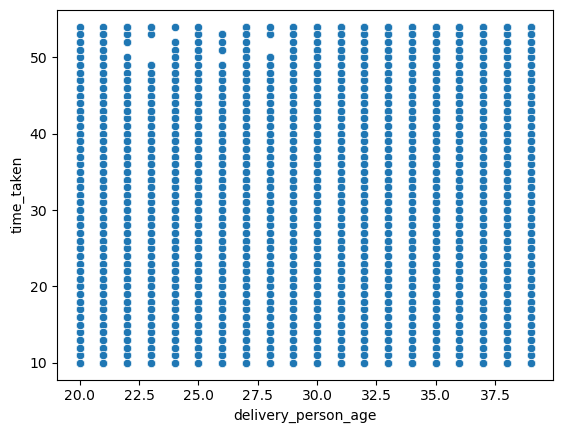

In [427]:
sns.scatterplot(data = delivery_data.to_pandas(), x = 'delivery_person_age', y = 'time_taken');

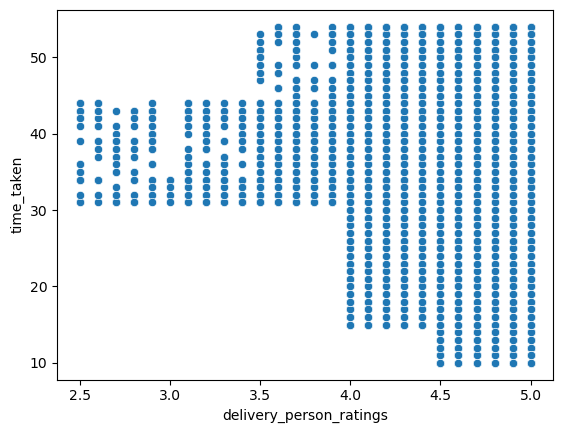

In [428]:
sns.scatterplot(data = delivery_data.to_pandas(), x = 'delivery_person_ratings', y = 'time_taken');

## Preparing Data for ML Process

In [429]:
data_matrix = delivery_data.to_dummies(pl.selectors.string(), drop_first = True)

In [430]:
data_matrix.head(n = 10)

delivery_person_age,delivery_person_ratings,weather_cloudy,weather_fog,weather_sandstorms,weather_stormy,weather_windy,traffic_density_jam,traffic_density_low,traffic_density_medium,type_of_order_buffet,type_of_order_drinks,type_of_order_meal,type_of_vehicle_electric_scooter,type_of_vehicle_scooter,festival_yes,city_metropolitian,city_semi-urban,distance,time_taken
i16,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f32,i16
37,4.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.03,24
34,4.5,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,20.18,33
23,4.4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1.55,26
38,4.7,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,7.79,21
32,4.6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,6.21,30
22,4.8,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,4.61,26
33,4.7,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,16.6,40
35,4.6,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,20.209999,32
22,4.8,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,19.98,34


In [431]:
X = data_matrix.select(pl.exclude('time_taken')).to_numpy()
Y = data_matrix.select(pl.col('time_taken')).to_numpy()

## Checking for Model Assumptions

In [432]:
mod_check = LinearRegression()
mod_check.fit(X, Y)
mod_pred = mod_check.predict(X)
mod_resid = Y - mod_pred
mod_SR = (mod_resid - np.mean(mod_resid))/np.std(mod_resid)

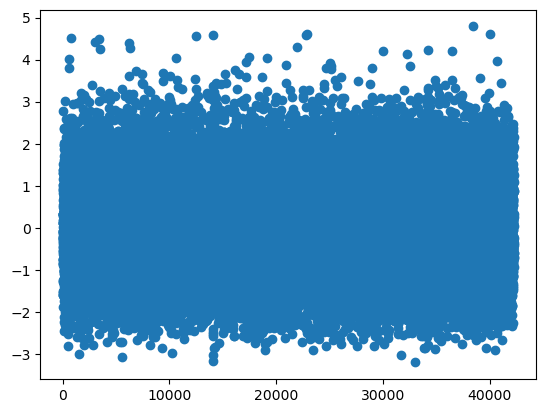

In [433]:
plt.scatter(x = np.arange(1, 42261), y = mod_SR);

In [434]:
print(np.mean(mod_SR))

3.7912278e-09


Given that the expectation of the residuals is approximately zero, that heteroskedasticity is not present, that there is no correlation of the residuals, and that there is linearity, one can conclude firmly that the conditions of Gauss-Markov Theorem are not violated here.  

It should be noted that these results were achieved in spite of individual scatterplots indicating that there was a lack of linearity. 

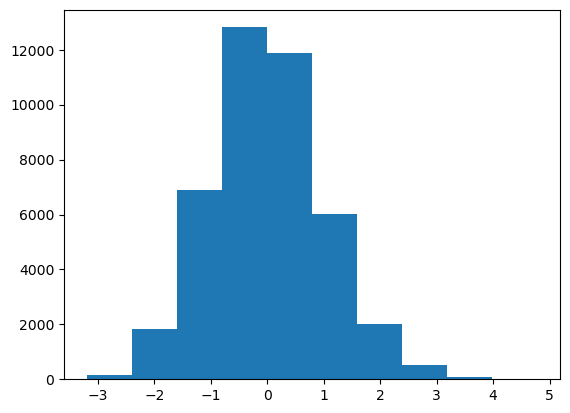

In [435]:
plt.hist(mod_SR);

Moreover, the histogram demonstrates that the residuals are approximately normally distributed, which means that statistical inference can be applied in this context. The purpose of this project is predictive, so this assumption is not as important, but it is still useful to be cognizant of this characteristic, as others may have different uses for the models. 

## Model Creation and Results

Four regression models will be used: OLS, lasso regression, ridge regression, and gradient boosted regression. The project will be performing five-fold cross validation, and to evaluate the models, it will use the scoring metrics of median absolute error, RMSE, and R-squared. Note that because all of the fitted models will employ the same amount of variables, adjusted R-squared is not an improvement over the standard R-squared value. 

In [436]:
mod_lm = LinearRegression()
mod_score = cross_validate(mod_lm, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([0.01675224, 0.01015997, 0.01063561, 0.00830483, 0.00931621]),
 'score_time': array([0.0026679 , 0.00148892, 0.00146818, 0.00141001, 0.00183487]),
 'test_neg_median_absolute_error': array([-4.23062325, -4.17127419, -4.15259361, -4.14918709, -4.21432495]),
 'test_neg_root_mean_squared_error': array([-6.30880165, -6.33337355, -6.29643345, -6.24638128, -6.3388257 ]),
 'test_r2': array([0.54810128, 0.5418835 , 0.54757096, 0.54000847, 0.54120562])}

In [437]:
mod_lasso = Lasso()
mod_score = cross_validate(mod_lasso, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([0.00666285, 0.00555182, 0.00552702, 0.00477386, 0.004812  ]),
 'score_time': array([0.00144315, 0.00220609, 0.0014379 , 0.00155807, 0.00152302]),
 'test_neg_median_absolute_error': array([-5.4588747 , -5.57152462, -5.56542683, -5.40715599, -5.60912704]),
 'test_neg_root_mean_squared_error': array([-8.09681129, -8.10980415, -8.09130669, -7.96489573, -8.16968346]),
 'test_r2': array([0.25565299, 0.24885031, 0.25286603, 0.25208373, 0.2379019 ])}

In [438]:
mod_ridge = Ridge()
mod_score = cross_validate(mod_ridge, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([0.00485086, 0.00473595, 0.00460482, 0.00453496, 0.00451994]),
 'score_time': array([0.00148821, 0.00151801, 0.00139999, 0.00141907, 0.0014348 ]),
 'test_neg_median_absolute_error': array([-4.2294817 , -4.17059708, -4.15366173, -4.14905453, -4.21406841]),
 'test_neg_root_mean_squared_error': array([-6.30874586, -6.33348131, -6.29623985, -6.24635077, -6.33900118]),
 'test_r2': array([0.54810927, 0.54186792, 0.5475988 , 0.54001301, 0.54118021])}

In [439]:
mod_XGB = xgb.XGBRegressor()
mod_score = cross_validate(mod_XGB, X, Y, 
                           scoring = ['neg_median_absolute_error', 'neg_root_mean_squared_error', 'r2'], 
                           cv = 5)
mod_score

{'fit_time': array([2.08479714, 2.13946986, 1.89295197, 1.81637502, 1.82118297]),
 'score_time': array([0.00991392, 0.00994492, 0.00988388, 0.00977683, 0.01100111]),
 'test_neg_median_absolute_error': array([-3.0704937 , -3.09253883, -3.05337572, -3.05771637, -3.08235312]),
 'test_neg_root_mean_squared_error': array([-4.52190495, -4.56694269, -4.58931303, -4.52514458, -4.55457258]),
 'test_r2': array([0.76783843, 0.7617917 , 0.75964309, 0.75858861, 0.76313781])}